In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

## Opening the data

In [2]:
data = pd.read_csv('bedoccupancy.csv',
                   parse_dates=['ADMISSION_DATE_TIME', 'DISCHARGE_DATE_TIME'])

In [3]:
data

,StudyID,Resident_Service.NAME,ADMISSION_DATE_TIME,DISCHARGE_DATE_TIME
0,458495,Internal Medicine B,2014-04-01 02:15:00,2014-04-03 16:30:00
1,1212197,Internal Medicine D,2014-04-01 04:21:00,2014-04-17 22:37:00
2,507244,Internal Medicine D,2014-04-01 04:30:00,2014-04-03 17:05:00
3,202030,Internal Medicine E,2014-04-01 04:30:00,2014-04-04 17:12:00
4,460987,Internal Medicine C,2014-04-01 07:50:00,2014-04-08 19:15:00
...,...,...,...,...
24280,266631,Internal Medicine D,2019-03-31 13:43:00,2019-04-03 16:53:00
24281,13479,Internal Medicine D,2019-03-31 16:26:00,2019-04-01 21:20:00
24282,1410780,Internal Medicine D,2019-03-31 18:20:00,2019-04-03 18:17:00
24283,839686,Internal Medicine B,2019-03-31 19:23:00,2019-04-04 18:42:00


## Datset: Admissions and Discharges per day

In [4]:
admission_start = data['ADMISSION_DATE_TIME'].iloc[0]
admission_end = data['ADMISSION_DATE_TIME'].iloc[-1]

discharge_start = data['DISCHARGE_DATE_TIME'].iloc[0]
discharge_end = data['DISCHARGE_DATE_TIME'].iloc[-1]

start = max(admission_start, discharge_start)
end = min(admission_end, discharge_end)

shifted_start = start + timedelta(days=1)
shifted_end = end + timedelta(days=1)

In [5]:
date_range = pd.date_range(start=start.date(), end=end.date())
shifted_range = pd.date_range(start=shifted_start.date(), end=shifted_end.date())

In [6]:
data_per_day = {'admissions': np.zeros(len(date_range)),
                'discharges': np.zeros(len(date_range)), 
                'occupancy':  np.zeros(len(date_range))}

In [7]:
i = 0
occupancy_before = 0
for date, shifted_date in zip(date_range, shifted_range):
    cond_1 = date <= data['ADMISSION_DATE_TIME']
    cond_2 = data['ADMISSION_DATE_TIME'] < shifted_date
    data_per_day['admissions'][i] = len(data[cond_1 & cond_2])
    
    cond_1 = date <= data['DISCHARGE_DATE_TIME']
    cond_2 = data['DISCHARGE_DATE_TIME'] < shifted_date
    data_per_day['discharges'][i] = len(data[cond_1 & cond_2])
    
    data_per_day['occupancy'][i] = occupancy_before + data_per_day['admissions'][i] - data_per_day['discharges'][i]
    occupancy_before = data_per_day['occupancy'][i]
    i = i+1

In [8]:
df = pd.DataFrame(data_per_day, index = date_range) 

In [9]:
df

,admissions,discharges,occupancy
2014-04-03,12.0,4.0,8.0
2014-04-04,11.0,9.0,10.0
2014-04-05,12.0,1.0,21.0
2014-04-06,8.0,3.0,26.0
2014-04-07,17.0,15.0,28.0
...,...,...,...
2019-03-27,15.0,19.0,111.0
2019-03-28,17.0,21.0,107.0
2019-03-29,16.0,20.0,103.0
2019-03-30,17.0,10.0,110.0


## Dataset: Day of the week

In [10]:
s = date_range.to_series()
days = s.dt.dayofweek.values
df['day'] = pd.DataFrame(days, index = date_range) 
df

,admissions,discharges,occupancy,day
2014-04-03,12.0,4.0,8.0,3
2014-04-04,11.0,9.0,10.0,4
2014-04-05,12.0,1.0,21.0,5
2014-04-06,8.0,3.0,26.0,6
2014-04-07,17.0,15.0,28.0,0
...,...,...,...,...
2019-03-27,15.0,19.0,111.0,2
2019-03-28,17.0,21.0,107.0,3
2019-03-29,16.0,20.0,103.0,4
2019-03-30,17.0,10.0,110.0,5


## Dataset: Holidays

In [11]:
holidays = pd.read_csv('HolidayDates.csv', parse_dates=['Holiday'])
holidays_values = np.array([])
for date in date_range:
    if len(holidays[holidays['Holiday'] == date]) == 0:
        aux = 0
    else: aux=1
    holidays_values=np.append(holidays_values, aux)

In [12]:
df['holiday'] = pd.DataFrame(holidays_values, index = date_range) 
df

,admissions,discharges,occupancy,day,holiday
2014-04-03,12.0,4.0,8.0,3,0.0
2014-04-04,11.0,9.0,10.0,4,0.0
2014-04-05,12.0,1.0,21.0,5,0.0
2014-04-06,8.0,3.0,26.0,6,0.0
2014-04-07,17.0,15.0,28.0,0,0.0
...,...,...,...,...,...
2019-03-27,15.0,19.0,111.0,2,0.0
2019-03-28,17.0,21.0,107.0,3,0.0
2019-03-29,16.0,20.0,103.0,4,0.0
2019-03-30,17.0,10.0,110.0,5,0.0


## Dataset: Weather

In [28]:
weather = pd.read_csv('weatherdata.csv', parse_dates=['dt_iso'], infer_datetime_format=True)
weather['dt_iso'] = weather['dt_iso'].astype('datetime64[ns]') 
weather.set_index('dt_iso')

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed
dt_iso,,,,,,,
2014-04-03 00:00:00,1.83,-2.61,0.00,2.30,1019.64,75,3.09
2014-04-03 01:00:00,1.68,-3.75,0.56,2.00,1020.32,64,4.12
2014-04-03 02:00:00,0.92,-4.11,0.00,1.30,1020.66,69,3.60
2014-04-03 03:00:00,0.82,-4.70,0.00,1.11,1021.67,64,4.12
2014-04-03 04:00:00,0.02,-5.23,-1.67,1.00,1022.30,69,3.77
...,...,...,...,...,...,...,...
2019-03-31 21:00:00,1.17,-4.03,0.00,2.78,1010.50,93,4.63
2019-03-31 22:00:00,0.82,-2.84,-0.56,1.67,1010.84,100,2.57
2019-03-31 22:00:00,0.82,-2.84,-0.56,1.67,1010.84,100,2.57


In [29]:
weather_per_day = {'temp': np.zeros(len(date_range)),
                'feels_like': np.zeros(len(date_range)), 
                'temp_min':  np.zeros(len(date_range)),
                'temp_max':  np.zeros(len(date_range))}

In [30]:
i = 0
occupancy_before = 0
for date, shifted_date in zip(date_range, shifted_range):
    cond_1 = date <= weather['dt_iso']
    cond_2 = weather['dt_iso'] < shifted_date
    weather_per_day['temp'][i] = weather[cond_1 & cond_2]['temp'].mean()
    weather_per_day['feels_like'][i] = weather[cond_1 & cond_2]['feels_like'].mean()
    weather_per_day['temp_min'][i] = weather[cond_1 & cond_2]['temp_min'].mean()
    weather_per_day['temp_max'][i] = weather[cond_1 & cond_2]['temp_max'].mean()

    i = i+1

In [31]:
df_weather = pd.DataFrame(weather_per_day, index = date_range) 

In [32]:
df_weather

,temp,feels_like,temp_min,temp_max
2014-04-03,0.236667,-4.625000,-1.404583,2.335417
2014-04-04,2.353929,-3.518214,-0.639286,4.970714
2014-04-05,2.683571,-5.528214,1.019643,4.161786
2014-04-06,0.907917,-4.641250,-1.264583,3.205417
2014-04-07,3.793750,-0.637917,0.904167,7.858333
...,...,...,...,...
2019-03-27,-0.729167,-5.525833,-2.935000,1.388750
2019-03-28,4.163333,-1.817500,1.362500,7.126250
2019-03-29,5.317083,1.726667,3.033333,7.530417
2019-03-30,3.933750,-0.053437,-0.351250,7.706563


In [33]:
df = pd.concat([df, df_weather], axis=1, sort=False)
df

,admissions,discharges,occupancy,day,holiday,temp,feels_like,temp_min,temp_max
2014-04-03,12.0,4.0,8.0,3,0.0,0.236667,-4.625000,-1.404583,2.335417
2014-04-04,11.0,9.0,10.0,4,0.0,2.353929,-3.518214,-0.639286,4.970714
2014-04-05,12.0,1.0,21.0,5,0.0,2.683571,-5.528214,1.019643,4.161786
2014-04-06,8.0,3.0,26.0,6,0.0,0.907917,-4.641250,-1.264583,3.205417
2014-04-07,17.0,15.0,28.0,0,0.0,3.793750,-0.637917,0.904167,7.858333
...,...,...,...,...,...,...,...,...,...
2019-03-27,15.0,19.0,111.0,2,0.0,-0.729167,-5.525833,-2.935000,1.388750
2019-03-28,17.0,21.0,107.0,3,0.0,4.163333,-1.817500,1.362500,7.126250
2019-03-29,16.0,20.0,103.0,4,0.0,5.317083,1.726667,3.033333,7.530417
2019-03-30,17.0,10.0,110.0,5,0.0,3.933750,-0.053437,-0.351250,7.706563


In [34]:
df.to_csv('data.csv',index=True)

## The Predictors

In [12]:
admissions_mean = df['admissions'].mean()
admissions_std = df['admissions'].mean()

In [13]:
df['smooth_month'] = df['admissions'].rolling(15, win_type='triang').mean()
df['smooth_week'] = df['admissions'].rolling(7, win_type='triang').mean()

df['admissions_norm'] = df['admissions']-df['smooth_month']

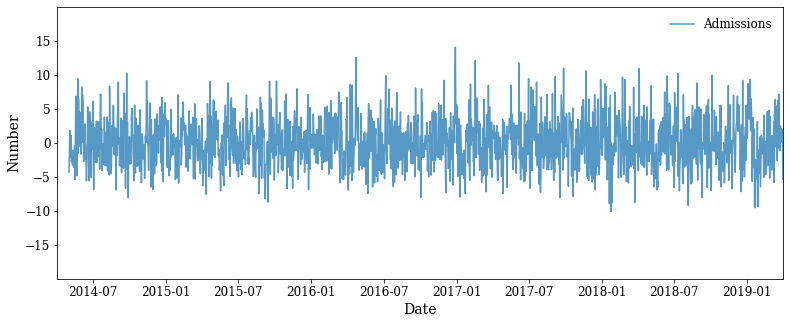

In [14]:
plt.figure(figsize=(13,5))
plt.plot(df.index, df['admissions_norm'].values, 
         alpha=0.75, label='Admissions')
#plt.plot(df.index, smooth_month.values-admissions_mean, alpha=0.55, label='Month smoothing')
#plt.plot(df.index, smooth_week.values-admissions_mean, alpha=0.55, label='Weekly smoothing')


plt.legend(loc='best', frameon=0, fontsize=12)
plt.ylabel('Number', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([min(df.index), max(df.index)])
plt.ylim([-1.5*admissions_std, 1.5*admissions_std ])
plt.savefig('occupancy_perday.png', bbox='thight')
plt.show()

In [15]:
df.dropna(subset = ["smooth_month"], inplace=True)
df

,admissions,discharges,occupancy,dayofweek,holidays,smooth_month,smooth_week,admissions_norm
2014-05-02,9.0,19.0,48.0,-0.5,1.0,13.320000,9.7500,-4.320000
2014-05-03,12.0,5.0,55.0,0.5,1.0,13.257778,10.0000,-1.257778
2014-05-04,15.0,1.0,69.0,1.0,1.0,13.173333,10.5000,1.826667
2014-05-05,11.0,14.0,66.0,1.0,1.0,13.095556,10.9375,-2.095556
2014-05-06,12.0,11.0,67.0,0.5,1.0,13.020000,11.7500,-1.020000
...,...,...,...,...,...,...,...,...
2019-03-27,15.0,19.0,111.0,-0.5,0.0,14.855556,15.7500,0.144444
2019-03-28,17.0,21.0,107.0,-1.0,0.0,14.984444,15.6875,2.015556
2019-03-29,16.0,20.0,103.0,-0.5,0.0,15.104444,15.8125,0.895556
2019-03-30,17.0,10.0,110.0,0.5,0.0,15.220000,16.0625,1.780000


In [16]:
len(df)
p=5
extra = 2

In [17]:
admissions_dict = {}
admissions_smooth = {}
days_dict = {}

for i in range(len(df)-p):
    admissions_dict[i] = df['admissions_norm'].iloc[i:i+p+1].values
    admissions_smooth[i] = df['smooth_month'].iloc[i:i+p+1].values
    days_dict[i] = df['dayofweek'].iloc[i:i+p+1].values

In [18]:
predictors = pd.DataFrame(admissions_dict).T
predictors_smooth = pd.DataFrame(admissions_smooth).T
days_lag = pd.DataFrame(days_dict).T

## Noisy data

In [19]:
y = predictors[p].values
predictors = predictors.drop([p], axis=1)

In [20]:
derivative = predictors.apply(np.gradient, axis=1, result_type='expand')
derivative[p] = derivative.mean(numeric_only=True, axis=1)
derivative[p+1] = derivative.std(numeric_only=True, axis=1)

new_columns = np.arange(p+extra, 2*(p+extra))
derivative.columns = new_columns

In [21]:
predictors[p] = predictors.mean(numeric_only=True, axis=1)
predictors[p+1] = predictors.std(numeric_only=True, axis=1)

In [22]:
predictors = pd.concat([predictors, derivative], axis=1, sort=False)
predictors = pd.concat([predictors, days_lag], axis=1, sort=False)
predictors['y']= y

In [23]:
predictors

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,0,1,2,3,4,5,y
0,-4.320000,-1.257778,1.826667,-2.095556,-1.020000,-1.373333,1.979022,3.062222,3.073333,-0.418889,...,1.075556,1.073778,1.811947,-0.5,0.5,1.0,1.0,0.5,-0.5,1.093333
1,-1.257778,1.826667,-2.095556,-1.020000,1.093333,-0.290667,1.491537,3.084444,-0.418889,-1.423333,...,2.113333,0.990000,1.662713,0.5,1.0,1.0,0.5,-0.5,-1.0,-2.768889
2,1.826667,-2.095556,-1.020000,1.093333,-2.768889,-0.592889,1.781741,-3.922222,-1.423333,1.594444,...,-3.862222,-1.697556,2.060335,1.0,1.0,0.5,-0.5,-1.0,-0.5,-1.613333
3,-2.095556,-1.020000,1.093333,-2.768889,-1.613333,-1.280889,1.318586,1.075556,1.594444,-0.874444,...,1.155556,0.319556,1.193312,1.0,0.5,-0.5,-1.0,-0.5,0.5,-2.442222
4,-1.020000,1.093333,-2.768889,-1.613333,-2.442222,-1.350222,1.367795,2.113333,-0.874444,-1.353333,...,-0.828889,-0.156000,1.237287,0.5,-0.5,-1.0,-0.5,0.5,1.0,-3.257778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,3.006667,-1.151111,0.673333,2.482222,1.302222,1.262667,1.463151,-4.157778,-1.166667,1.816667,...,-1.180000,-0.874667,1.980635,-0.5,0.5,1.0,1.0,0.5,-0.5,0.144444
1786,-1.151111,0.673333,2.482222,1.302222,0.144444,0.690222,1.206190,1.824444,1.816667,0.314444,...,-1.157778,0.325778,1.334455,0.5,1.0,1.0,0.5,-0.5,-1.0,2.015556
1787,0.673333,2.482222,1.302222,0.144444,2.015556,1.323556,0.852634,1.808889,0.314444,-1.168889,...,1.871111,0.636444,1.126074,1.0,1.0,0.5,-0.5,-1.0,-0.5,0.895556
1788,2.482222,1.302222,0.144444,2.015556,0.895556,1.368000,0.822853,-1.180000,-1.168889,0.356667,...,-1.120000,-0.547333,0.746121,1.0,0.5,-0.5,-1.0,-0.5,0.5,1.780000


In [24]:
predictors.to_csv('data.csv',index=False)

## Smooth data

In [25]:
y_s = predictors_smooth[p].values
predictors_smooth = predictors_smooth.drop([p], axis=1)

In [26]:
derivative = predictors_smooth.apply(np.gradient, axis=1, result_type='expand')
derivative[p] = derivative.mean(numeric_only=True, axis=1)
derivative[p+1] = derivative.std(numeric_only=True, axis=1)

new_columns = np.arange(p+extra, 2*(p+extra))
derivative.columns = new_columns

In [27]:
predictors_smooth[p] = predictors_smooth.mean(numeric_only=True, axis=1)
predictors_smooth[p+1] = predictors_smooth.std(numeric_only=True, axis=1)

In [28]:
predictors_smooth = pd.concat([predictors_smooth, derivative], axis=1, sort=False)
predictors_smooth = pd.concat([predictors_smooth, days_lag], axis=1, sort=False)
predictors_smooth['y']= y_s

In [29]:
predictors_smooth

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,0,1,2,3,4,5,y
0,13.320000,13.257778,13.173333,13.095556,13.020000,13.173333,0.107891,-0.062222,-0.073333,-0.081111,...,-0.075556,-0.073778,0.006309,-0.5,0.5,1.0,1.0,0.5,-0.5,12.906667
1,13.257778,13.173333,13.095556,13.020000,12.906667,13.090667,0.121354,-0.084444,-0.081111,-0.076667,...,-0.113333,-0.090000,0.013053,0.5,1.0,1.0,0.5,-0.5,-1.0,12.768889
2,13.173333,13.095556,13.020000,12.906667,12.768889,12.992889,0.142440,-0.077778,-0.076667,-0.094444,...,-0.137778,-0.102444,0.024978,1.0,1.0,0.5,-0.5,-1.0,-0.5,12.613333
3,13.095556,13.020000,12.906667,12.768889,12.613333,12.880889,0.173337,-0.075556,-0.094444,-0.125556,...,-0.155556,-0.119556,0.030442,1.0,0.5,-0.5,-1.0,-0.5,0.5,12.442222
4,13.020000,12.906667,12.768889,12.613333,12.442222,12.750222,0.205527,-0.113333,-0.125556,-0.146667,...,-0.171111,-0.144000,0.021893,0.5,-0.5,-1.0,-0.5,0.5,1.0,12.257778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,13.993333,14.151111,14.326667,14.517778,14.697778,14.337333,0.251240,0.157778,0.166667,0.183333,...,0.180000,0.174667,0.010690,-0.5,0.5,1.0,1.0,0.5,-0.5,14.855556
1786,14.151111,14.326667,14.517778,14.697778,14.855556,14.509778,0.251850,0.175556,0.183333,0.185556,...,0.157778,0.174222,0.010120,0.5,1.0,1.0,0.5,-0.5,-1.0,14.984444
1787,14.326667,14.517778,14.697778,14.855556,14.984444,14.676444,0.234486,0.191111,0.185556,0.168889,...,0.128889,0.163556,0.024010,1.0,1.0,0.5,-0.5,-1.0,-0.5,15.104444
1788,14.517778,14.697778,14.855556,14.984444,15.104444,14.832000,0.207254,0.180000,0.168889,0.143333,...,0.120000,0.147333,0.023743,1.0,0.5,-0.5,-1.0,-0.5,0.5,15.220000


In [307]:
predictors_smooth.to_csv('data_smooth.csv',index=False)